In [15]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install matplotlib
!pip3 install shap
!pip3 install scikit-learn
!pip3 install numpy
!pip3 install xgboost
!pip3 install tqdm
!pip3 install tensorflow
!pip3 install keras
!pip3 install statsmodels
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from itertools import product
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, auc
from itertools import combinations
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller

#keras crashing probably due to macOS silicon
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout
#from keras_tuner import RandomSearch





If you want to obtain the results of the experiments for the "Model + Sentiment + (optionally price)" experiments, you have to load in the following line of code the 'combined_train_final_1.csv'.
Alternatively, in order to obtain the results of the "Model + Raw Sentiment + (optionally price) experiments, you have to load in the following line of code the 'combined_train_final_raw.csv' (as mentioned in the paper, the '...raw.csv' files contain more unprocessed and unfiltered text).

In [16]:
df = pd.read_csv('combined_train_final_1.csv', parse_dates=['date'])

df['btc_log_return'] = np.log(df['btc_close_price'] / df['btc_close_price'].shift(1))
df['btc_target_log_return'] = df['btc_log_return'].shift(-1)
df['eth_log_return'] = np.log(df['eth_close_price'] / df['eth_close_price'].shift(1))
df['eth_target_log_return'] = df['eth_log_return'].shift(-1)
df['btc_current_movement'] = df['btc_target_label'].shift(1) #shift target label to next day (to get current price movement as feature)
df['eth_current_movement'] = df['eth_target_label'].shift(1) 
features = ['subjectivity', 'polarity', 'compound', 'neg', 'neu', 'pos'] #+['btc_close_price', 'eth_close_price', 'btc_log_return',  'eth_log_return', 'btc_current_movement', 'eth_current_movement'] + ['btc_target_label', 'eth_target_label', 'btc_target_log_return', 'eth_target_log_return']
#df.dropna(inplace=True)
print(len(df))
df.drop(df.tail(1).index,inplace=True) 
df.drop(df.head(1).index,inplace=True) 
print(df[['date','eth_close_price','eth_log_return', 'eth_target_log_return','eth_current_movement', 'eth_target_label']].head(10))
print(len(df))

1733
         date  eth_close_price  eth_log_return  eth_target_log_return  \
1  2017-11-12       307.907990       -0.021758               0.028204   
2  2017-11-13       316.716003        0.028204               0.063948   
3  2017-11-14       337.631012        0.063948              -0.012740   
4  2017-11-15       333.356995       -0.012740              -0.007325   
5  2017-11-16       330.924011       -0.007325               0.004432   
6  2017-11-17       332.394012        0.004432               0.044766   
7  2017-11-18       347.612000        0.044766               0.019300   
8  2017-11-19       354.385986        0.019300               0.034239   
9  2017-11-20       366.730011        0.034239              -0.017409   
10 2017-11-21       360.401001       -0.017409               0.054668   

    eth_current_movement  eth_target_label  
1                    0.0                 1  
2                    1.0                 1  
3                    1.0                 0  
4          

In [17]:
# Training balances:
print("Class Balance BTC: ", "0s: ", np.count_nonzero(df['btc_target_label'] == 0)/len(df['btc_target_label']), "1s: ",np.count_nonzero(df['btc_target_label'] == 1)/len(df['btc_target_label']))
print("Class Balance ETH: ", "0s: ", np.count_nonzero(df['eth_target_label'] == 0)/len(df['eth_target_label']), "1s: ",np.count_nonzero(df['eth_target_label'] == 1)/len(df['eth_target_label']))

Class Balance BTC:  0s:  0.4702484113229347 1s:  0.5297515886770653
Class Balance ETH:  0s:  0.48642403235124204 1s:  0.5135759676487579


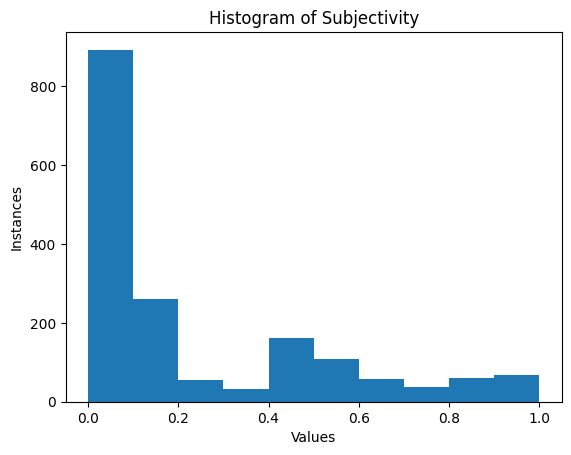

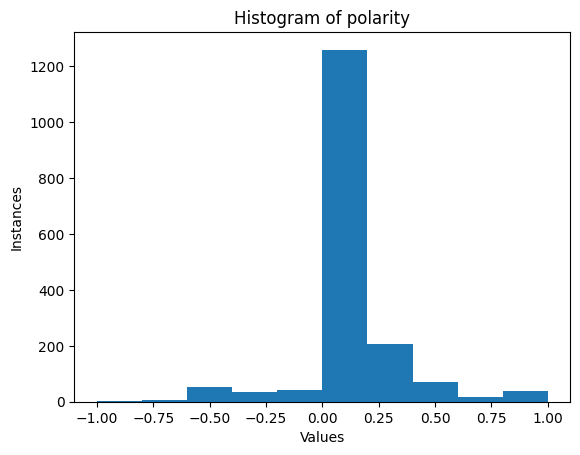

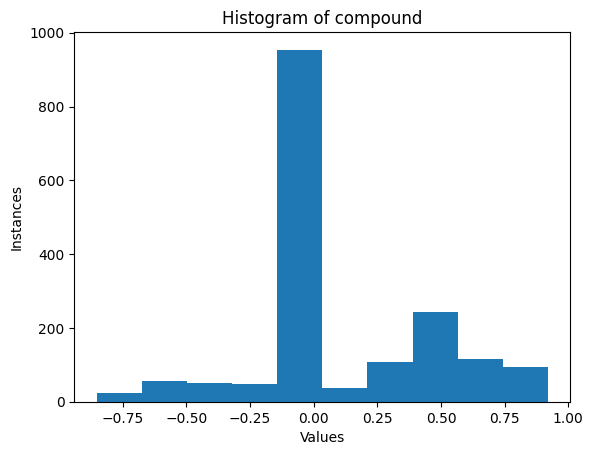

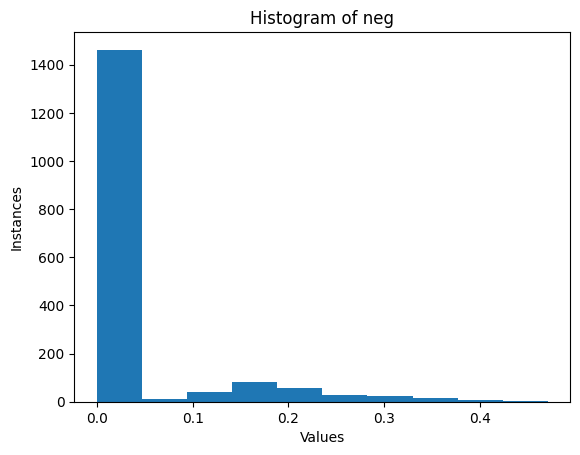

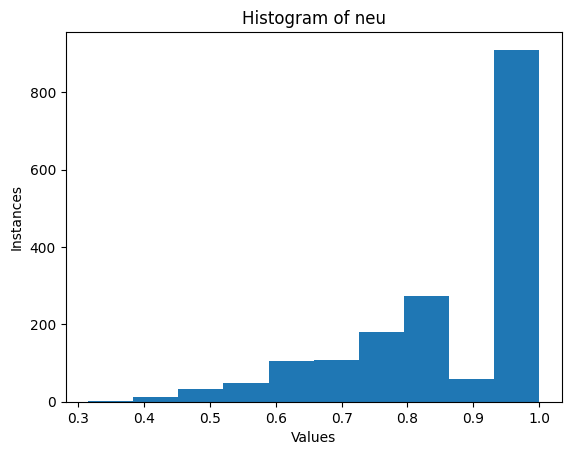

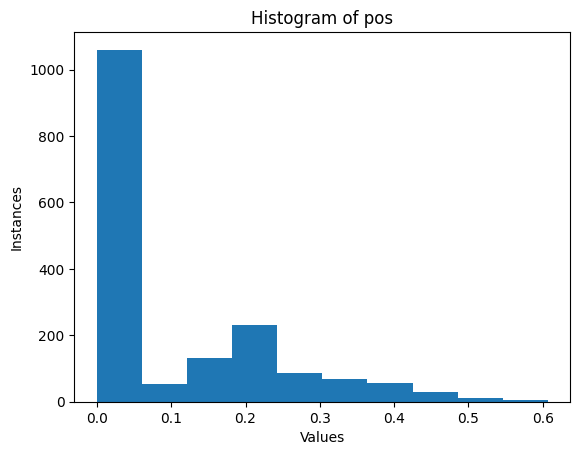

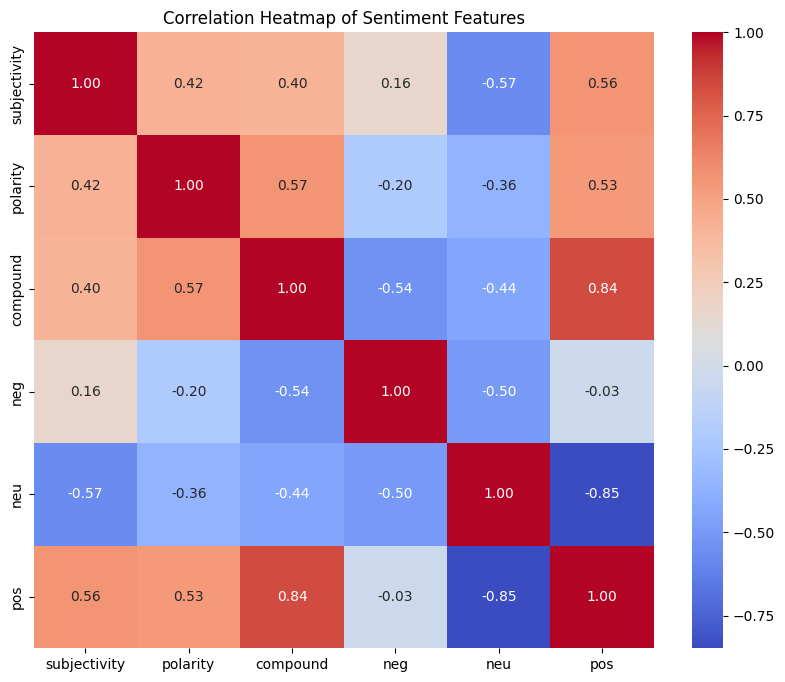

In [18]:
features = ['cryptobert_sentiment', 'cryptobert_sentiment_2', 'subjectivity', 'polarity', 'compound', 'neg', 'neu', 'pos'] + ['btc_target_label', 'eth_target_label']


plt.hist(df['subjectivity'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set the label for the x-axis
plt.ylabel('Instances')  # Set the label for the y-axis
plt.title('Histogram of Subjectivity')  # Set the title of the histogram
plt.show()

plt.hist(df['polarity'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set the label for the x-axis
plt.ylabel('Instances')  # Set the label for the y-axis
plt.title('Histogram of polarity')  # Set the title of the histogram
plt.show()

plt.hist(df['compound'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set the label for the x-axis
plt.ylabel('Instances')  # Set the label for the y-axis
plt.title('Histogram of compound')  # Set the title of the histogram
plt.show()

plt.hist(df['neg'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set the label for the x-axis
plt.ylabel('Instances')  # Set the label for the y-axis
plt.title('Histogram of neg')  # Set the title of the histogram
plt.show()

plt.hist(df['neu'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set the label for the x-axis
plt.ylabel('Instances')  # Set the label for the y-axis
plt.title('Histogram of neu')  # Set the title of the histogram
plt.show()

plt.hist(df['pos'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  
plt.ylabel('Instances')  
plt.title('Histogram of pos')  
plt.show()
contin_features = ['subjectivity', 'polarity', 'compound', 'neg', 'neu', 'pos']
correlation_matrix = df[contin_features].corr()
# Plotting the heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Sentiment Features")
plt.show()


In [19]:
# Perform the Augmented Dickey-Fuller test on the btc_log_return to check for stationarity
coins = ['btc', 'eth']
for coin in coins:
    adf_test_result = adfuller(df[f'{coin}_log_return'].dropna())  # Drop NaN values for the test

    # Create a summary of the test result
    adf_test_summary = {
        'ADF Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        'Critical Values': adf_test_result[4]
    }

    print(adf_test_summary)

{'ADF Statistic': -41.90016415756114, 'p-value': 0.0, 'Critical Values': {'1%': -3.4341355661448856, '5%': -2.8632121160561694, '10%': -2.5676601871094924}}
{'ADF Statistic': -22.29793223783906, 'p-value': 0.0, 'Critical Values': {'1%': -3.4341399541217137, '5%': -2.8632140530328685, '10%': -2.567661218506194}}


In [20]:
# pos has high linear  + correlation w/ compound and high - corr. w/ neu --> drop it
df.drop(['pos'], inplace=True, axis=1)

In the following code snippet depending on the experiment you want to run, you have to alter three lines of code. 

1) At line 188, you can choose which features to use as input. E.g. in order to obtain the Table V of the paper's Results Section for a specific configuration, let's say i.e. find the best model with only sentiment used, you have to comment out the price features at the afforementioned line.

2) At line 20, as a follow up of the 1) you have to put the list with the correct # of features depending your configuration (sentiment only, sentiment+prices or any other combination you may want to try)

2) At line 228 you have to change the test file based only on the following: If you want the dataset with the classic filtering and preprocessing you use the 'combined_test_final_1.csv'. If you want to obtain the results of the raw sentiment, as described in the paper, you must switch to the 'combined_test_final_raw.csv'. Be careful so that the train files you loaded on the beginning of the notebook, depending on the kind of preprocessing used, match their test file counterparts (the naming convention is the same for both).  

In [21]:
def tune_model(X, y, model, param_grid, n_features, n_splits=5, n_iter=100, random_state=42, scoring='accuracy'):
    """
    Function to tune hyperparameters and select the best feature subset for a given model.
    
    Parameters:
    - X: DataFrame of features
    - y: Series or array of target
    - model: The model (e.g., RandomForestClassifier, XGBClassifier) to be tuned
    - param_grid: The hyperparameter grid for RandomizedSearchCV
    - n_splits: Number of splits for TimeSeriesSplit cross-validation
    - n_iter: Number of iterations for RandomizedSearchCV (not used, we use GridSearch so every combo is tried out)
    - random_state: Random seed for reproducibility
    - scoring: Scoring method for RandomizedSearchCV
    
    Returns:
    - best_score: Best accuracy score obtained
    - best_model: The model with the best hyperparameters
    """

    n_features = [4,5,6,7,8,9] # change based on scenarios (sentiment only: [4,5,6,7], sentiment+prices: [4,5,6,7,8,9])
    tscv = TimeSeriesSplit(n_splits=n_splits)
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, XGBClassifier, AdaBoostClassifier)):
        rfe = RFE(estimator=model)
        pipeline = Pipeline(steps=[('rfe', rfe), ('model', model)])
        updated_param_grid = {
            'rfe__n_features_to_select': n_features, 
            **{f'model__{key}': value for key, value in param_grid.items()}
        }   

    elif isinstance(model, LogisticRegression):
        model = LogisticRegression(penalty='l1', solver='liblinear', random_state=random_state)
        scaler = StandardScaler()  
        pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
        updated_param_grid = {f'model__{key}': value for key, value in param_grid.items()}
    
    # Mutual Information feature selection for KNN
    elif isinstance(model, KNeighborsClassifier):
        # Use SelectKBest with mutual_info_classif for KNN
        selector = SelectKBest(mutual_info_classif)  # Select the top 5 features
        pipeline = Pipeline(steps=[('selector', selector), ('model', model)])
        updated_param_grid = {
            'selector__k': n_features,  # Try different numbers of features
            **{f'model__{key}': value for key, value in param_grid.items()}
        }


    # RFE for SVC with non-linear kernels or L1 regularization for linear kernel
    elif isinstance(model, SVC):
        if 'linear' in param_grid.get('kernel', []):
            # For linear kernel, use L1 regularization for feature selection
            model = SVC(kernel='linear', random_state=random_state)
            scaler = StandardScaler()  # Scaling is important for SVC
            pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
            updated_param_grid = {f'model__{key}': value for key, value in param_grid.items()}
        else:
            # Use RFE for non-linear kernels like 'rbf', 'poly'
            rfe = RFE(estimator=model)
            scaler = StandardScaler()  # Scaling is important for SVC
            pipeline = Pipeline(steps=[('scaler', scaler), ('rfe', rfe), ('model', model)])
            updated_param_grid = {
                'rfe__n_features_to_select': n_features,  # Adjust feature selection
                **{f'model__{key}': value for key, value in param_grid.items()}
            }
    
    best_score = 0
    #best_features = None
    best_model = None
    
    # Loop over all possible feature subsets
    #for r in range(1, X.shape[1] + 1):
    #    for feature_subset in combinations(X.columns, r):
    #        X_subset = X[list(feature_subset)]    
    '''
    search = RandomizedSearchCV(estimator=pipeline, 
                            param_distributions=updated_param_grid, 
                            n_iter=n_iter, 
                            cv=tscv, 
                            scoring=scoring, 
                            random_state=random_state)
    '''
    search = GridSearchCV(estimator=pipeline, 
                                param_grid=updated_param_grid,  
                                cv=tscv, 
                                scoring=scoring)
    
    search.fit(X, y)
    
    # Check if this combination gives a better score
    if search.best_score_ > best_score:
        best_score = search.best_score_
        #best_features = feature_subset
        best_model = search.best_estimator_

    if 'rfe' in best_model.named_steps:
        selected = best_model.named_steps['rfe'].support_
        selected_features = X.columns[selected]
        print("Selected features:", selected_features)

    return best_score, best_model


# Define models and their parameter grids

## SOS ########
### PUT imbalanced variable into your models #####

models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [3, 6, 10, 15, 20],
            'learning_rate': [0.001, 0.01, 0.1],
            'subsample': [0.6, 0.8, 1.0]
        }
    },
    "K-Nearest Neighbors (KNN)": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            'n_neighbors': [2, 3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42),
        "param_grid": {
            'C': [0.01, 0.1, 1, 10, 50, 100],
            'solver': ['liblinear']
        }
    },
    "SVM": {
        "model": SVC(random_state=42),
        "param_grid": {
            'C': [0.01, 0.1, 1, 3, 5, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.001, 0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.001, 0.01, 0.1, 1]
        }
    },
    "Extra Trees": {
        "model": ExtraTreesClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

coins = ['btc', 'eth']
for coin in coins:
    print(coin)
# Including extra features like Current Price/Current Price Movement
#['btc_close_price', 'eth_close_price', 'btc_log_return',  'eth_log_return', 'btc_current_movement', 'eth_current_movement'] 

#['btc_target_label', 'eth_target_label', 'btc_target_log_return', 'eth_target_log_return']
    
    #normalize close prices
    scaler_p = MinMaxScaler()
    df[f'{coin}_close_price_normalized'] = scaler_p.fit_transform(df[[f'{coin}_close_price']])
    

    features = ['cryptobert_sentiment', 'cryptobert_sentiment_2', 'subjectivity', 'polarity', 'compound','neg', 'neu']\
             +  [f'{coin}_current_movement'] + [f'{coin}_log_return'] 
               
    X = df[features]
    y = df[f'{coin}_target_label']

    results = []
    # Train and print results for each model
    for model_name, model_info in tqdm(models.items()):
        print(f"Training {model_name}...")
        best_score, best_model = tune_model(
            X, 
            y, 
            model_info['model'], 
            model_info['param_grid'],
            n_features=X.shape[1]
        )
        results.append({
            'model_name': model_name,
            'best_score': best_score,
            'best_model': best_model
        })
        #print(f"Best Model for {model_name}: {best_model}")
        #print(f"Best Score for {model_name}: {best_score}")
        #print(f"Best Feature Subset for {model_name}: {best_features}")
        print("---------------------------------------------------")


    # Find the overall best model
    best_result = max(results, key=lambda x: x['best_score'])
    best_model = best_result['best_model']
    # Print the overall best model
    print(f"Overall Best Model {coin}:")
    print(f"Model Name: {best_result['model_name']}")
    print(f"Best Score: {best_result['best_score']}")
    #print(f"Best Feature Subset: {best_result['best_features']}")
    print(f"Best Model: {best_result['best_model']}")

##################################################
    print('-------- TESTING --------')
    df_test = pd.read_csv('combined_test_final_1.csv', parse_dates=['date'])
    df_test[f'{coin}_log_return'] = np.log(df_test[f'{coin}_close_price'] / df_test[f'{coin}_close_price'].shift(1))
    df_test[f'{coin}_target_log_return'] = df_test[f'{coin}_log_return'].shift(-1)
    df_test[f'{coin}_current_movement'] = df_test[f'{coin}_target_label'].shift(1) #shift target label to next day (to get current price movement as feature)
    df_test[f'{coin}_close_price_normalized'] = scaler_p.transform(df_test[[f'{coin}_close_price']])
    #print(len(df_test))
    df_test.dropna(inplace=True)
    #print(len(df_test))
    
    features = ['cryptobert_sentiment', 'cryptobert_sentiment_2', 'subjectivity', 'polarity', 'compound', 'neg', 'neu']\
             + [f'{coin}_current_movement'] + [f'{coin}_log_return']
    X_test = np.array(df_test[features])
    y_test = np.array(df_test[[f'{coin}_target_label']])

    print("Determine baseline: ", np.count_nonzero(y_test == 0)/len(y_test), np.count_nonzero(y_test == 1)/len(y_test))
    
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")

btc


  0%|          | 0/8 [00:00<?, ?it/s]

Training Random Forest...


 12%|█▎        | 1/8 [1:20:10<9:21:14, 4810.58s/it]

Selected features: Index(['subjectivity', 'polarity', 'compound', 'neg', 'neu', 'btc_log_return'], dtype='object')
---------------------------------------------------
Training XGBoost...


 25%|██▌       | 2/8 [2:22:19<6:57:24, 4174.16s/it]

Selected features: Index(['cryptobert_sentiment', 'cryptobert_sentiment_2', 'subjectivity',
       'polarity', 'compound', 'neg', 'neu', 'btc_current_movement',
       'btc_log_return'],
      dtype='object')
---------------------------------------------------
Training K-Nearest Neighbors (KNN)...


 50%|█████     | 4/8 [2:22:32<1:31:45, 1376.34s/it]

---------------------------------------------------
Training Logistic Regression...
---------------------------------------------------
Training SVM...


 62%|██████▎   | 5/8 [2:22:39<44:07, 882.44s/it]   

---------------------------------------------------
Training Gradient Boosting...


 75%|███████▌  | 6/8 [2:45:05<34:40, 1040.16s/it]

Selected features: Index(['polarity', 'compound', 'neu', 'btc_log_return'], dtype='object')
---------------------------------------------------
Training AdaBoost...


/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

Selected features: Index(['polarity', 'compound', 'neu', 'btc_log_return'], dtype='object')
---------------------------------------------------
Training Extra Trees...


100%|██████████| 8/8 [3:32:10<00:00, 1591.27s/it]
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(


Selected features: Index(['subjectivity', 'polarity', 'compound', 'neg', 'neu', 'btc_log_return'], dtype='object')
---------------------------------------------------
Overall Best Model btc:
Model Name: Random Forest
Best Score: 0.5444444444444445
Best Model: Pipeline(steps=[('rfe',
                 RFE(estimator=RandomForestClassifier(random_state=42),
                     n_features_to_select=6)),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])
-------- TESTING --------
Determine baseline:  0.4769736842105263 0.5230263157894737
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       145
           1       0.62      0.65      0.63       159

    accuracy                           0.61       304
   macro avg       0.60      0.60      0.60       304
w

  0%|          | 0/8 [00:00<?, ?it/s]

Training Random Forest...


 12%|█▎        | 1/8 [1:20:43<9:25:06, 4843.73s/it]

Selected features: Index(['cryptobert_sentiment', 'subjectivity', 'polarity', 'compound', 'neg',
       'neu', 'eth_log_return'],
      dtype='object')
---------------------------------------------------
Training XGBoost...


/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 25%|██▌       | 2/8 [1:53:12<5:14:04, 3140.82s/it]

Selected features: Index(['polarity', 'compound', 'neg', 'eth_log_return'], dtype='object')
---------------------------------------------------
Training K-Nearest Neighbors (KNN)...


 50%|█████     | 4/8 [1:53:25<1:09:06, 1036.52s/it]

---------------------------------------------------
Training Logistic Regression...
---------------------------------------------------
Training SVM...


 62%|██████▎   | 5/8 [1:53:32<33:15, 665.13s/it]   

---------------------------------------------------
Training Gradient Boosting...


 75%|███████▌  | 6/8 [2:16:02<29:56, 898.22s/it]

Selected features: Index(['cryptobert_sentiment', 'cryptobert_sentiment_2', 'subjectivity',
       'polarity', 'compound', 'neg', 'neu', 'eth_log_return'],
      dtype='object')
---------------------------------------------------
Training AdaBoost...


/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

Selected features: Index(['cryptobert_sentiment', 'subjectivity', 'polarity', 'compound', 'neg',
       'neu', 'eth_log_return'],
      dtype='object')
---------------------------------------------------
Training Extra Trees...


100%|██████████| 8/8 [3:03:22<00:00, 1375.37s/it]

Selected features: Index(['cryptobert_sentiment', 'subjectivity', 'polarity', 'compound', 'neg',
       'neu', 'eth_log_return'],
      dtype='object')
---------------------------------------------------
Overall Best Model eth:
Model Name: K-Nearest Neighbors (KNN)
Best Score: 0.5416666666666666
Best Model: Pipeline(steps=[('selector',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_classif at 0x1772bb9c0>)),
                ('model', KNeighborsClassifier())])
-------- TESTING --------
Determine baseline:  0.47039473684210525 0.5296052631578947
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       143
           1       0.55      0.52      0.53       161

    accuracy                           0.52       304
   macro avg       0.52      0.52      0.52       304
weighted avg       0.53      0.52      0.52       304

Accuracy: 0.5230



/Users/xarisk/miniconda3/envs/aueb/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [22]:
#print(best_model)
#print(coin)
'''
print("Determine baseline: ", np.count_nonzero(y_test == 0)/len(y_test), np.count_nonzero(y_test == 1)/len(y_test))
print(f"Accuracy: {accuracy:.4f}")
y_pred = [1 for i in range(len(y_test))]
y_test = np.array(df_test[['btc_target_label']])
print("Determine baseline: ", np.count_nonzero(y_test == 0)/len(y_test), np.count_nonzero(y_test == 1)/len(y_test))
print(len(y_test))
print(classification_report(y_test, y_pred))
'''

'\nprint("Determine baseline: ", np.count_nonzero(y_test == 0)/len(y_test), np.count_nonzero(y_test == 1)/len(y_test))\nprint(f"Accuracy: {accuracy:.4f}")\ny_pred = [1 for i in range(len(y_test))]\ny_test = np.array(df_test[[\'btc_target_label\']])\nprint("Determine baseline: ", np.count_nonzero(y_test == 0)/len(y_test), np.count_nonzero(y_test == 1)/len(y_test))\nprint(len(y_test))\nprint(classification_report(y_test, y_pred))\n'